In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range

## Convection starts around 1853 in piControl experiment but not in LE2 experiment, check reason

Difference between namelist_cfg's:

```
<    sn_wndi     = 'CESM2-LE2_ens1011.001_U10x'  ,   24.    ,  'U10x'   ,  .true.    , .false. , 'yearly'  , 'w_bicub_CESM2.nc'  , 'Uwnd'   ,  ''
<    sn_wndj     = 'CESM2-LE2_ens1011.001_U10y'  ,   24.    ,  'U10y'   ,  .true.    , .false. , 'yearly'  , 'w_bicub_CESM2.nc'  , 'Vwnd'   ,  ''
<    sn_qsr      = 'CESM2-LE2_ens1011.001_FSDS_bias_corr'  ,  24.  ,  'FSDS'   ,  .true.    , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
<    sn_qlw      = 'CESM2-LE2_ens1011.001_FLDS_bias_corr'  ,  24.  ,  'FLDS'   ,  .true.    , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
<    sn_tair     = 'CESM2-LE2_ens1011.001_TREFHT_bias_corr',  24.  ,  'TREFHT' ,  .true.    , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
<    sn_humi     = 'CESM2-LE2_ens1011.001_QREFHT_bias_corr',  24.  ,  'QREFHT' ,  .true.    , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
<    sn_prec     = 'CESM2-LE2_ens1011.001_PRECT' ,    24.   ,  'PRECT'  ,  .true.   , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
<    sn_snow     = 'CESM2-LE2_ens1011.001_PRECS' ,    24.   ,  'PRECS'  ,  .true.   , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
<    sn_slp      = 'CESM2-LE2_ens1011.001_PSL'   ,    24.   ,  'PSL'    ,  .true.   , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''

---

>    sn_wndi     = 'CESM2-piControl_ens001_U10x'  ,   24.   ,  'U10x'   ,  .true.    , .false. , 'yearly'  , 'w_bicub_CESM2.nc' , 'Uwnd'   ,  ''
>    sn_wndj     = 'CESM2-piControl_ens001_U10y'  ,   24.   ,  'U10y'   ,  .true.    , .false. , 'yearly'  , 'w_bicub_CESM2.nc' , 'Vwnd'   ,  ''
>    sn_qsr      = 'CESM2-piControl_ens001_FSDS_bias_corr'  ,  24.  ,  'FSDS'   ,  .true. , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
>    sn_qlw      = 'CESM2-piControl_ens001_FLDS_bias_corr'  ,  24.  ,  'FLDS'   ,  .true. , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
>    sn_tair     = 'CESM2-piControl_ens001_TREFHT_bias_corr',  24.  ,  'TREFHT' ,  .true. , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
>    sn_humi     = 'CESM2-piControl_ens001_QREFHT_bias_corr',  24.  ,  'QREFHT' ,  .true. , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
>    sn_prec     = 'CESM2-piControl_ens001_PRECT' ,   -1.   ,  'PRECT'  ,  .true.   , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
>    sn_snow     = 'CESM2-piControl_ens001_PRECS' ,   -1.   ,  'PRECS'  ,  .true.   , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''
>    sn_slp      = 'CESM2-piControl_ens001_PSL'   ,   24.   ,  'PSL'    ,  .true.   , .false. , 'yearly'  , 'w_bilin_CESM2.nc'  ,   ''     ,  ''

```

So, the main difference is that PRECT and PRECS are monthly, or potentially something related to when/how the files were created
- submit piControl_test2 experiment which just uses the precipitation files from the LE2 experiment
- files look like they were created around the same point in time, but I should also look at my bias correction comparison for these files

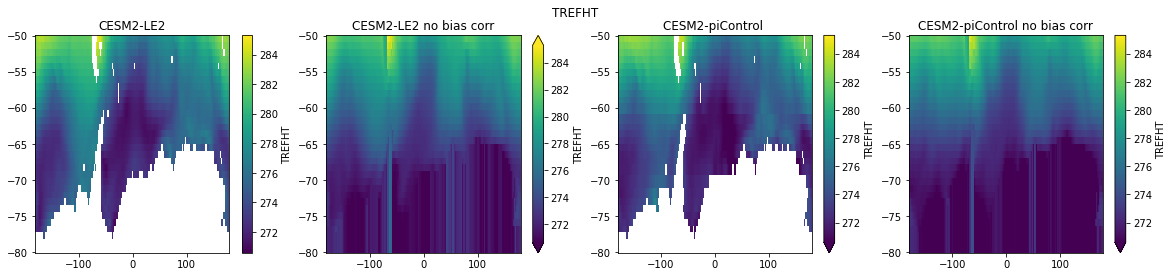

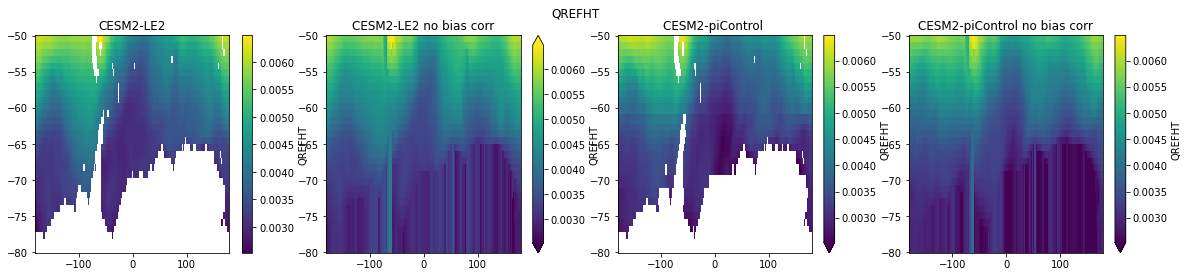

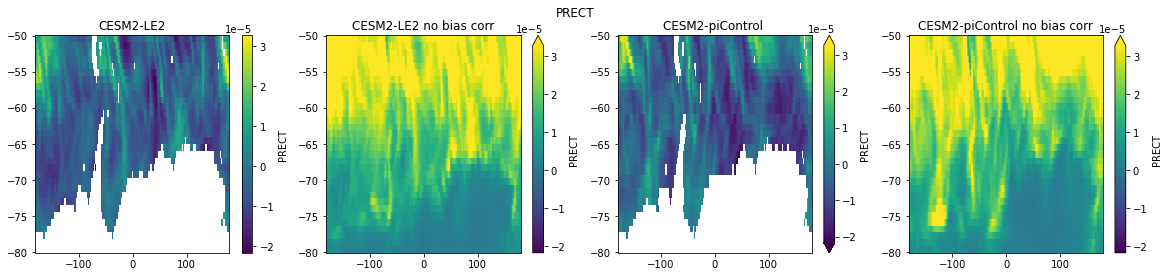

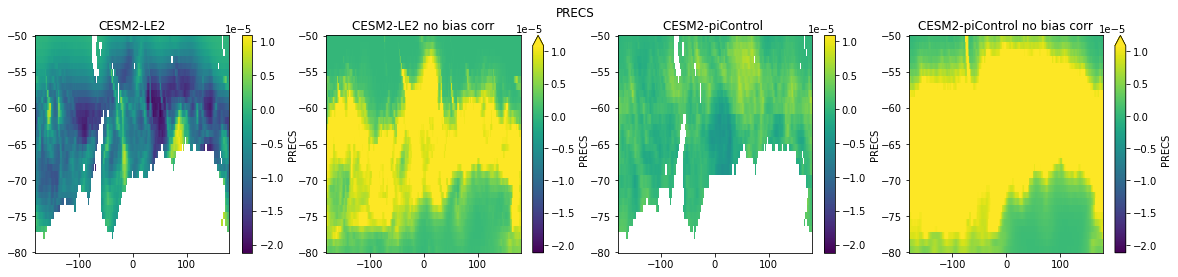

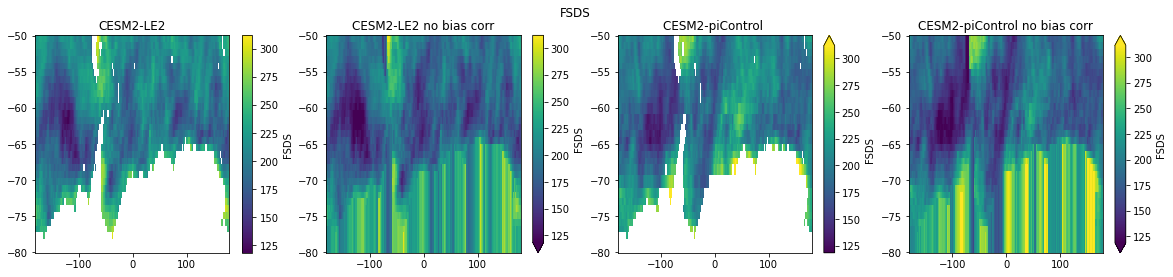

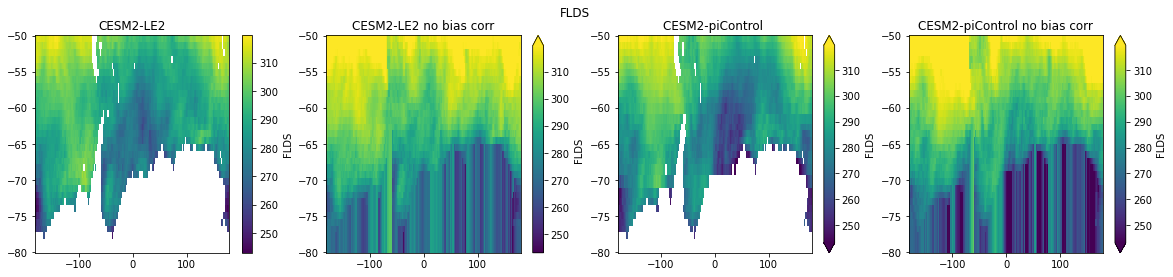

In [6]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

for v in ['TREFHT','QREFHT','PRECT','PRECS','FSDS','FLDS']:

    cesm2_LE2_nobc = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_{v}_y1979.nc').sel(lat=slice(-80,-50)).isel(time=slice(0,31)).mean(dim='time')
    bias_corr      = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_{v}_bias_corr.nc').sel(lat=slice(-80,-50))
    cesm2_LE2      = cesm2_LE2_nobc[v] + bias_corr[v]

    cesm2_piC_nobc = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/piControl/processed/CESM2-piControl_ens001_{v}_y1979.nc').sel(lat=slice(-80,-50)).isel(time=slice(0,31)).mean(dim='time')
    cesm2_piC      = cesm2_piC_nobc[v] + bias_corr[v]

    fig, ax = plt.subplots(1,4, figsize=(20,4))
    
    vmax = cesm2_LE2.max()
    vmin = cesm2_LE2.min()
    cesm2_LE2.sortby('lon').plot(ax=ax[0], vmin=vmin, vmax=vmax)
    cesm2_LE2_nobc[v].sortby('lon').plot(ax=ax[1], vmin=vmin, vmax=vmax)
    cesm2_piC.sortby('lon').plot(ax=ax[2], vmin=vmin, vmax=vmax)
    cesm2_piC_nobc[v].sortby('lon').plot(ax=ax[3], vmin=vmin, vmax=vmax)

    for axis in ax.ravel():
        axis.set_ylabel('')
        axis.set_xlabel('')
    ax[0].set_title('CESM2-LE2')
    ax[1].set_title('CESM2-LE2 no bias corr')
    ax[2].set_title('CESM2-piControl ')
    ax[3].set_title('CESM2-piControl no bias corr')
    fig.suptitle(v)

### Look at how different the atmospheric forcing is from the ERA5 forcing

In [45]:
era5_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/ERA5-forcing/drowned_1h/'
cesm2_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/bias-corrected/'

In [46]:
def print_min_max_mean(era5var, cesm2var, month):

    era5_var = xr.open_dataset(f'{era5_dir}{era5var}_y1979m{month:02}.nc').sel(latitude=slice(-50,-90)).mean(dim='time')
    if cesm2var in ['PSL','U10x','U10y']:
        cesm2_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'
        cesm2_var = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_ens1011.001_{cesm2var}_y1851.nc').sel(lat=slice(-90,-50))
    else:
        cesm2_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/bias-corrected/'
        cesm2_var = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_ens1011.001_{cesm2var}_bias_corr_y1851.nc').sel(lat=slice(-90,-50))
    cesm2_var = cesm2_var.isel(time=(cesm2_var.time.dt.month==month)).mean(dim='time')
    
    print(f'Month: {month:02}; {cesm2var}')
    if cesm2var in ['PRECT','PRECS']:
        print(f'ERA5: {era5_var[era5var].min().values:.2e}-{era5_var[era5var].max().values:.2e}, mean: {era5_var[era5var].mean().values:.2e}')
        print(f'CESM2: {cesm2_var[cesm2var].min().values:.2e}-{cesm2_var[cesm2var].max().values:.2e}, mean: {cesm2_var[cesm2var].mean().values:.2e}')
    else:
        print(f'ERA5: {era5_var[era5var].min().values:.1f}-{era5_var[era5var].max().values:.1f}, mean: {era5_var[era5var].mean().values:.1f}')
        print(f'CESM2: {cesm2_var[cesm2var].min().values:.1f}-{cesm2_var[cesm2var].max().values:.1f}, mean: {cesm2_var[cesm2var].mean().values:.1f}')

    era5_var.close()
    cesm2_var.close()
    return

In [30]:
era5vars  = ['t2m', 'msdwlwrf', 'msdwswrf', 'msl', 'msr', 'mtpr', 'u10', 'v10']
cesm2vars = ['TREFHT', 'FLDS', 'FSDS', 'PSL', 'PRECS', 'PRECT', 'U10x', 'U10y']
for era5var, cesm2var in zip(era5vars, cesm2vars):
    for month in range(1,12):
        print_min_max_mean(era5var, cesm2var, month)

Month: 01; TREFHT
ERA5: 268.9-286.4, mean: 273.6
CESM2: 269.0-284.0, mean: 274.4
Month: 02; TREFHT
ERA5: 257.6-286.9, mean: 272.1
CESM2: 264.9-284.7, mean: 273.3
Month: 03; TREFHT
ERA5: 251.9-285.6, mean: 269.6
CESM2: 253.3-285.9, mean: 269.3
Month: 04; TREFHT
ERA5: 246.6-284.7, mean: 266.8
CESM2: 245.5-283.5, mean: 265.7
Month: 05; TREFHT
ERA5: 243.1-282.7, mean: 264.4
CESM2: 242.2-282.5, mean: 262.6
Month: 06; TREFHT
ERA5: 241.7-281.9, mean: 262.2
CESM2: 240.2-281.3, mean: 259.8
Month: 07; TREFHT
ERA5: 240.8-282.1, mean: 260.1
CESM2: 238.8-280.2, mean: 259.3
Month: 08; TREFHT
ERA5: 241.7-281.2, mean: 261.1
CESM2: 239.8-280.8, mean: 258.8
Month: 09; TREFHT
ERA5: 247.7-281.4, mean: 262.6
CESM2: 243.5-280.9, mean: 260.3
Month: 10; TREFHT
ERA5: 250.5-282.0, mean: 265.0
CESM2: 250.0-281.4, mean: 263.8
Month: 11; TREFHT
ERA5: 259.5-282.9, mean: 269.2
CESM2: 259.7-282.3, mean: 269.1
Month: 01; FLDS
ERA5: 203.7-331.1, mean: 268.6
CESM2: 227.0-326.3, mean: 276.8
Month: 02; FLDS
ERA5: 195.6-33

CESM2 precipitation (snowfall and liquid seems to be negative sometimes which doesn't seem right)...

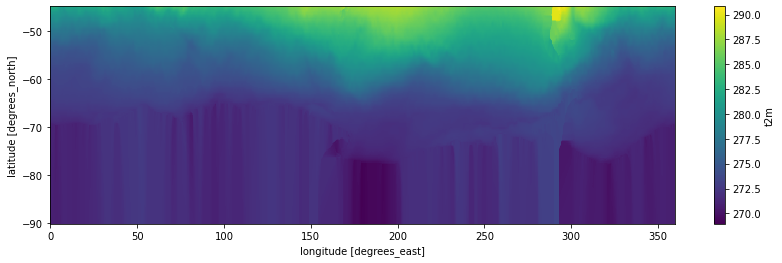

In [5]:
era5_T.t2m.plot(figsize=(14,4))

In [31]:
cesm2_dir1 = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/bias-corrected/'
cesm2_dir2 = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'

In [108]:
PRECT_bias = xr.open_dataset(f'{cesm2_dir2}CESM2-LE2_PRECT_bias_corr.nc').sel(lat=slice(-90,-50))
PRECS_bias = xr.open_dataset(f'{cesm2_dir2}CESM2-LE2_PRECS_bias_corr.nc').sel(lat=slice(-90,-50))

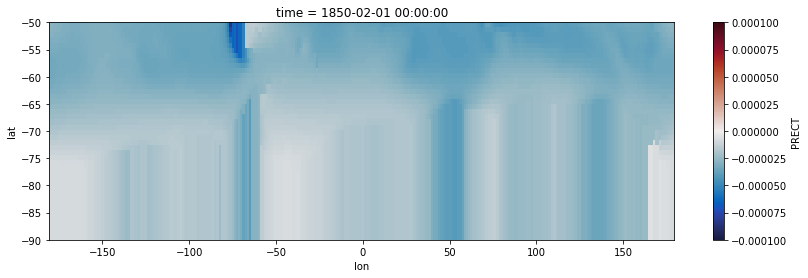

In [110]:
PRECT_bias.sortby('lon').PRECT.plot(figsize=(14,4), ylim=(-90,-50), vmin=-1e-4, vmax=1e-4, cmap=cmocean.cm.balance)

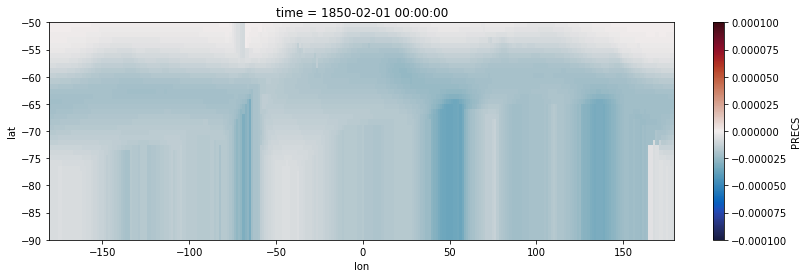

In [96]:
PRECS_bias.sortby('lon').PRECS.plot(figsize=(14,4), ylim=(-90,-50), vmin=-1e-4, vmax=1e-4, cmap=cmocean.cm.balance)

In [73]:
era5_ds = xr.open_mfdataset(f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/ERA5-forcing/era5_tp_1979_daily_averages.nc').sel(latitude=slice(-50,-90))
print(era5_ds.tp.min().values, era5_ds.tp.max().values)

0.0 0.0034717713


In [83]:
era5_ds = xr.open_mfdataset(f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/ERA5-forcing/era5_sf_1979_daily_averages.nc').sel(latitude=slice(-50,-90))
print(era5_ds.sf.min().values, era5_ds.sf.max().values)
era5_ds = xr.where(era5_ds<0, 0, era5_ds)
print(era5_ds.sf.min().values, era5_ds.sf.max().values)

-4.656613e-10 0.003308111
0.0 0.003308111


In [120]:
month=5

era5_PRECT = xr.open_dataset(f'{era5_dir}mtpr_y1979m{month:02}.nc').sel(latitude=slice(-50,-90)).mean(dim='time').mtpr
era5_PRECS = xr.open_dataset(f'{era5_dir}msr_y1979m{month:02}.nc').sel(latitude=slice(-50,-90)).mean(dim='time').msr

cesm2_PRECT_bias_corr = xr.open_dataset(f'{cesm2_dir1}CESM2-LE2_ens1011.001_PRECT_bias_corr_y1850.nc').sel(lat=slice(-90,-50)).PRECT
cesm2_PRECT_base      = xr.open_dataset(f'{cesm2_dir2}CESM2-LE2_ens1011.001_PRECT_y1850.nc').sel(lat=slice(-90,-50)).PRECT
cesm2_PRECT_1979      = xr.open_dataset(f'{cesm2_dir2}CESM2-LE2_ens1011.001_PRECT_y1979.nc').sel(lat=slice(-90,-50)).PRECT

cesm2_PRECS_bias_corr = xr.open_dataset(f'{cesm2_dir1}CESM2-LE2_ens1011.001_PRECS_bias_corr_y1850.nc').sel(lat=slice(-90,-50)).PRECS
cesm2_PRECS_base      = xr.open_dataset(f'{cesm2_dir2}CESM2-LE2_ens1011.001_PRECS_y1850.nc').sel(lat=slice(-90,-50)).PRECS
cesm2_PRECS_1979      = xr.open_dataset(f'{cesm2_dir2}CESM2-LE2_ens1011.001_PRECS_y1979.nc').sel(lat=slice(-90,-50)).PRECS

In [121]:
cesm2_PRECT_bias_corr = cesm2_PRECT_bias_corr.isel(time=(cesm2_PRECT_bias_corr.time.dt.month==month)).mean(dim='time')
cesm2_PRECT_base      = cesm2_PRECT_base.isel(time=(cesm2_PRECT_base.time.dt.month==month)).mean(dim='time')
cesm2_PRECT_1979      = cesm2_PRECT_1979.isel(time=(cesm2_PRECT_1979.time.dt.month==month)).mean(dim='time')
cesm2_PRECS_bias_corr = cesm2_PRECS_bias_corr.isel(time=(cesm2_PRECS_bias_corr.time.dt.month==month)).mean(dim='time')
cesm2_PRECS_base      = cesm2_PRECS_base.isel(time=(cesm2_PRECS_base.time.dt.month==month)).mean(dim='time')
cesm2_PRECS_1979      = cesm2_PRECS_1979.isel(time=(cesm2_PRECS_1979.time.dt.month==month)).mean(dim='time')

In [122]:
cesm2_PRECT_fixed = xr.where(cesm2_PRECT_bias_corr<0, 0, cesm2_PRECT_bias_corr)
cesm2_PRECS_fixed = xr.where(cesm2_PRECS_bias_corr<0, 0, cesm2_PRECS_bias_corr)

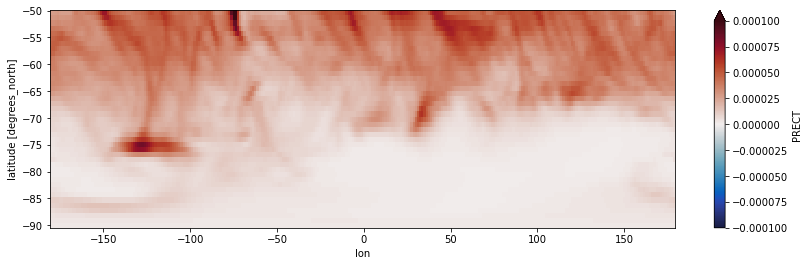

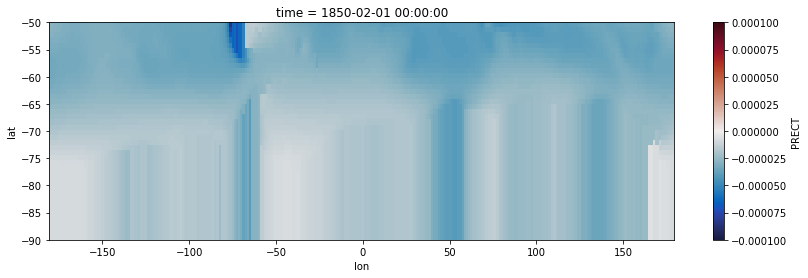

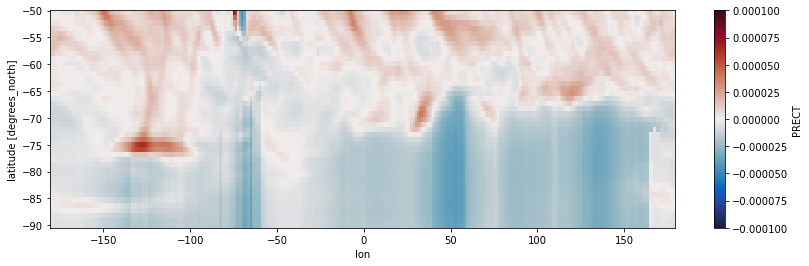

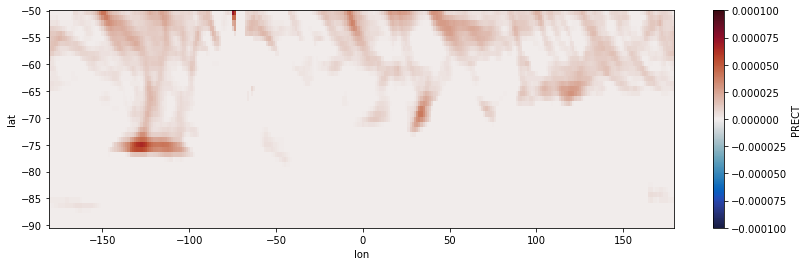

In [125]:
cesm2_PRECT_base.sortby('lon').plot(figsize=(14,4), vmin=-1e-4, vmax=1e-4, cmap=cmocean.cm.balance)
PRECT_bias.sortby('lon').PRECT.plot(figsize=(14,4), ylim=(-90,-50), vmin=-1e-4, vmax=1e-4, cmap=cmocean.cm.balance)
cesm2_PRECT_bias_corr.sortby('lon').plot(figsize=(14,4), vmin=-1e-4, vmax=1e-4, cmap=cmocean.cm.balance)
cesm2_PRECT_fixed.sortby('lon').plot(figsize=(14,4), vmin=-1e-4, vmax=1e-4, cmap=cmocean.cm.balance)

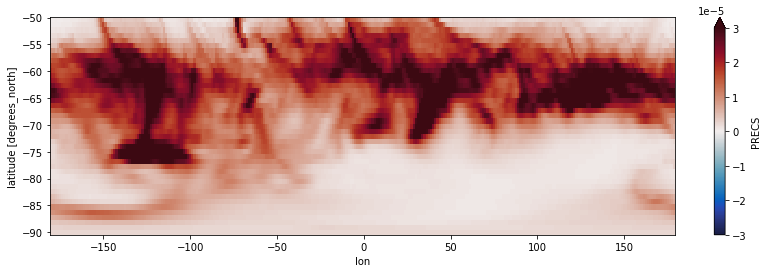

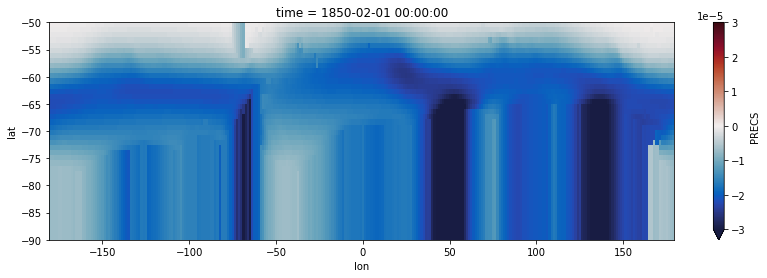

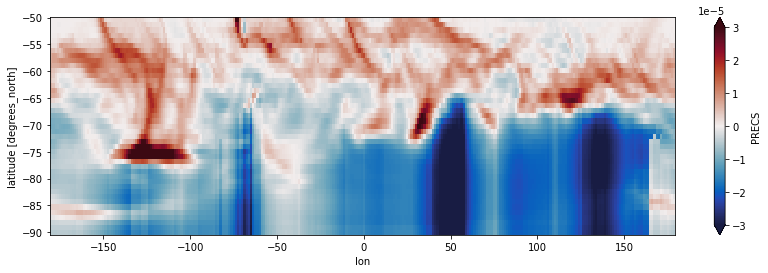

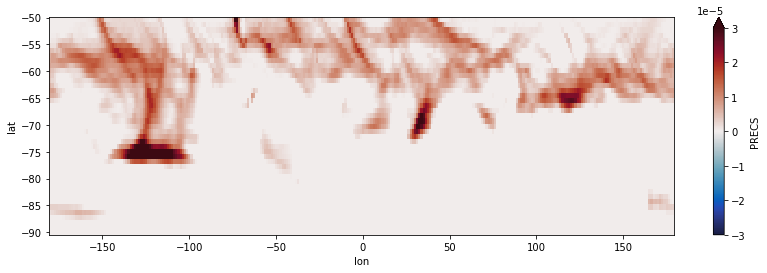

In [126]:
cesm2_PRECS_base.sortby('lon').plot(figsize=(14,4), vmin=-3e-5, vmax=3e-5, cmap=cmocean.cm.balance)
PRECS_bias.sortby('lon').PRECS.plot(figsize=(14,4), ylim=(-90,-50), vmin=-3e-5, vmax=3e-5, cmap=cmocean.cm.balance)
cesm2_PRECS_bias_corr.sortby('lon').plot(figsize=(14,4), vmin=-3e-5, vmax=3e-5, cmap=cmocean.cm.balance)
cesm2_PRECS_fixed.sortby('lon').plot(figsize=(14,4), vmin=-3e-5, vmax=3e-5, cmap=cmocean.cm.balance)

In [103]:
dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/'
ds1 = xr.open_dataset(f'{dir}b.e21.BHISTsmbb.f09_g17.LE2-1071.004.cam.h1.FLDS.18500101-18591231.nc').sel(lat=slice(-90,-50))
ds2 = xr.open_dataset(f'{dir}b.e21.BHISTsmbb.f09_g17.LE2-1071.004.cam.h1.FSDS.18500101-18591231.nc').sel(lat=slice(-90,-50))
ds3 = xr.open_dataset(f'{dir}b.e21.BHISTsmbb.f09_g17.LE2-1071.004.cam.h1.PSL.18500101-18591231.nc').sel(lat=slice(-90,-50))
ds4 = xr.open_dataset(f'{dir}b.e21.BHISTsmbb.f09_g17.LE2-1071.004.cam.h1.QREFHT.18500101-18591231.nc').sel(lat=slice(-90,-50))
ds5 = xr.open_dataset(f'{dir}b.e21.BHISTsmbb.f09_g17.LE2-1071.004.cam.h1.TREFHT.18500101-18591231.nc').sel(lat=slice(-90,-50))

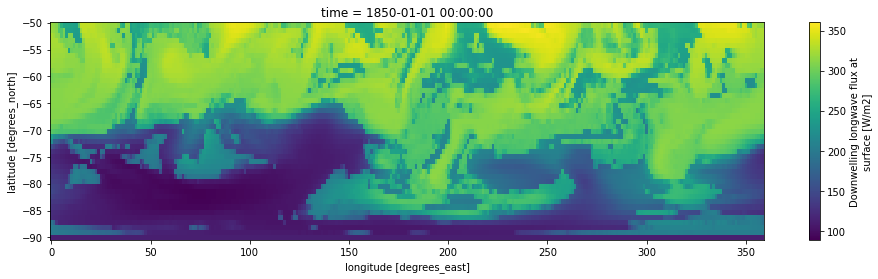

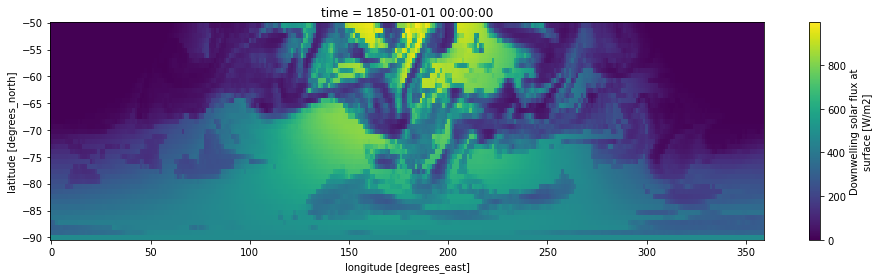

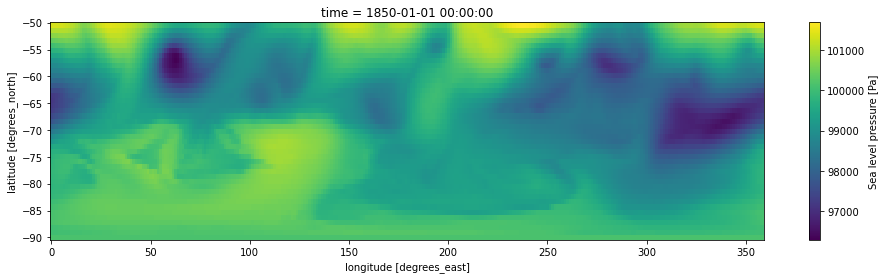

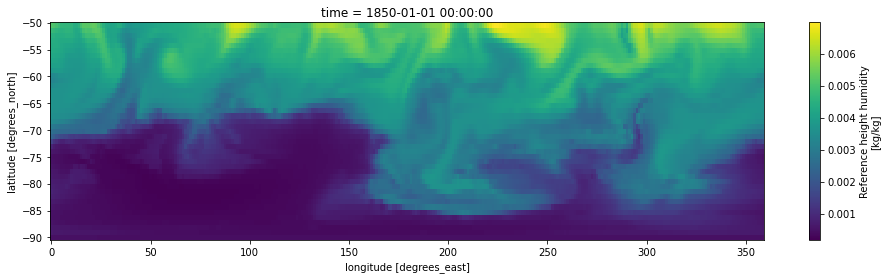

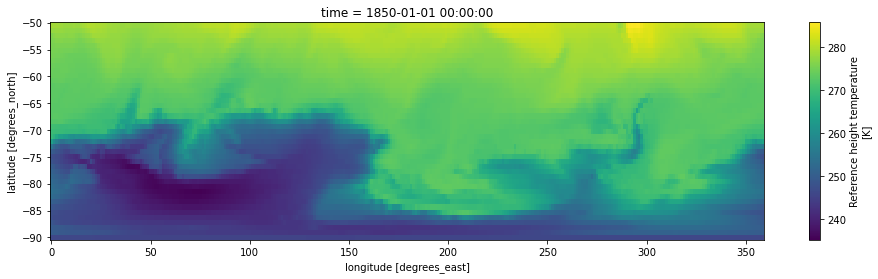

In [104]:
ds1.FLDS.isel(time=0).plot(figsize=(16,4))
ds2.FSDS.isel(time=0).plot(figsize=(16,4))
ds3.PSL.isel(time=0).plot(figsize=(16,4))
ds4.QREFHT.isel(time=0).plot(figsize=(16,4))
ds5.TREFHT.isel(time=0).plot(figsize=(16,4))